#　卷积神经网络中的经典数据结构


- LeNet
- AlexNet
- VGG
- ResNet


In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt

# 加载FashiMNist数据集

In [2]:
transforms = torchvision.transforms.ToTensor()
training_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms
)
testing_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transforms
)

# 辅助函数

In [3]:
def accuracy(y_hat, y):
    max_indices = torch.max(y_hat, dim=1)[1]
    return (y == max_indices).to(dtype=torch.float32).mean()


def accuracy_on(model, data_iter):
    acc = []
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        acc.append(accuracy(y_hat, y))
    return torch.tensor(acc).mean().item()


def train(training_iter, testing_iter, model, loss, optimizer, device, epoch=20, plot=True):
    training_loss = []
    training_acc = []
    testing_acc = []
    for i in range(epoch):
        epoch_loss = 0
        epoch_acc = 0
        for X, y in training_iter:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            epoch_loss += l.item()
            epoch_acc += accuracy(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        training_loss.append(epoch_loss / len(training_iter))
        training_acc.append(epoch_acc / len(training_iter))
        testing_acc.append(accuracy_on(model, testing_iter))
        print(
            f'the loss of epoch {i}: {training_loss[-1]:.4f}, accuracy on training set: {training_acc[-1]:.4f}, accuracy on testing set: {testing_acc[-1]:.4f}')
    if plot == False:
        return
    plt.plot(training_loss, label='training_loss')
    plt.plot(training_acc, label='training_acc')
    plt.plot(testing_acc, label='testing_acc')
    plt.legend()
    plt.show()

# 构建LeNet模型

<img src='./images/lenet.svg' width=900>

- 默认结构下，必须使用大的学习率>0.5，如果使用0.1，则模型训练的非常慢，至少要10个epoch以上
- 如果Conv后不加Sigmoid，则可以使用学习率0.1即可。
- 原来尝试的batch_size是256，acc只能到85%左右，后来不经意调整为了25，发现acc轻松到90

the loss of epoch 0: 2.3112, accuracy on training set: 0.1029, accuracy on testing set: 0.1004
the loss of epoch 1: 1.8850, accuracy on training set: 0.2606, accuracy on testing set: 0.5574
the loss of epoch 2: 0.7332, accuracy on training set: 0.7135, accuracy on testing set: 0.7684
the loss of epoch 3: 0.5490, accuracy on training set: 0.7868, accuracy on testing set: 0.7317
the loss of epoch 4: 0.4768, accuracy on training set: 0.8201, accuracy on testing set: 0.7759
the loss of epoch 5: 0.4338, accuracy on training set: 0.8374, accuracy on testing set: 0.7898
the loss of epoch 6: 0.4025, accuracy on training set: 0.8498, accuracy on testing set: 0.8265
the loss of epoch 7: 0.3768, accuracy on training set: 0.8587, accuracy on testing set: 0.8440
the loss of epoch 8: 0.3583, accuracy on training set: 0.8657, accuracy on testing set: 0.8542
the loss of epoch 9: 0.3416, accuracy on training set: 0.8721, accuracy on testing set: 0.8519
the loss of epoch 10: 0.3274, accuracy on training

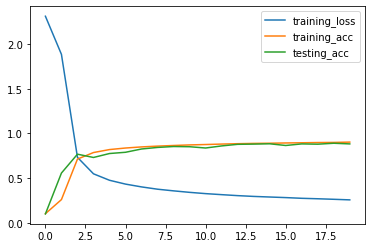

In [4]:
batch_size = 64
learning_rate = 0.9
epoch = 20
device = torch.device('cuda:3')

training_iter = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
testing_iter = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(400, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84,10)
)
def parameters_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
model.apply(parameters_init)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train(training_iter, testing_iter, model, loss, optimizer, device=device, epoch=20, plot=True)